**Executed:** Sat Feb  8 18:11:34 2020<br>**Duration:** 2999 seconds.<br>**Autogenerated from:** [Base Experiment.ipynb](saved experiments/Baseline Augmentation + Inception-ResNet V2 Model + epoch60 + opt-SGD-lr0.001.ipynb)

---

In [1]:
# NOTEBOOK parameters
# see nbrun docs on github

IMG_SHAPE = (150,150)
BATCH_SIZE = 32
EPOCH = 2
MODEL = 'Lite Test' # 'Inception-ResNet V2 Model' #
DATA_GEN_CONFIG = 'Baseline Augmentation'
OPT = 'opt-SGD-lr0.001'

In [2]:
# Cell inserted during automated execution.
DATA_GEN_CONFIG = 'Baseline Augmentation'
MODEL = 'Inception-ResNet V2 Model'
EPOCH = 60
OPT = 'opt-SGD-lr0.001'

In [3]:
!curl -L -o noahs_utils.py https://gist.github.com/bantucaravan/1956003e25c056c550a088542b41dc91/raw/noahs_utility_funcs.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0


100 12726  100 12726    0     0  31729      0 --:--:-- --:--:-- --:--:-- 31729


In [4]:
import os
import glob
import re
import datetime as dt
from collections import defaultdict
import sys
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

#import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint#, TensorBoard
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Flatten, Dense

from noahs_utils import *
import build_data_gens
import build_models

In [5]:
if False:
    import noahs_utils
    importlib.reload(noahs_utils)

In [6]:
if False:
    import GIST_git_clone.noahs_utility_funcs
    from GIST_git_clone.noahs_utility_funcs import *
    importlib.reload(GIST_git_clone.noahs_utility_funcs)

**Data** from https://www.kaggle.com/asdasdasasdas/garbage-classification

Get number of images in each class folder

In [7]:
img_dir = '/Users/noahchasekmacfoy/Desktop/local projects/Trash-life/data/Garbage Classification Dataset/IMAGES'
tot_len = 0
for _dir in [i for i in os.listdir(img_dir) if not i.startswith('.')]:
    _len = len(os.listdir(os.path.join(img_dir, _dir)))
    tot_len += _len
    print(_dir, ': ', _len)
print(tot_len)

paper :  594
metal :  410
cardboard :  403
trash :  137
glass :  501
plastic :  482
2527


Listed test/val/train split from txt files

In [8]:
#file = '../data/Garbage Classification Dataset/one-indexed-files-notrash_test.txt'
files = glob.glob('../data/Garbage Classification Dataset/*_*.txt')
files = {re.findall(r'.*_(\w*).txt',f)[0]: pd.read_csv(f, sep=' ', header=None) for i, f in enumerate(files)}

Create df listing train/val/test split

In [9]:
df = pd.concat(files.values(), axis=0, keys=files.keys()).reset_index(level=0)
df.columns = ['split', 'img', '1-indexed-label']
df.index = range(len(df))
df['label'] = df['img'].str.extract(r'([a-z]+)\d+.jpg')
df

,split,img,1-indexed-label,label
0,test,paper70.jpg,2,paper
1,test,paper380.jpg,2,paper
2,test,cardboard31.jpg,3,cardboard
3,test,glass12.jpg,1,glass
4,test,paper169.jpg,2,paper
...,...,...,...,...
2522,train,cardboard6.jpg,3,cardboard
2523,train,glass283.jpg,1,glass
2524,train,metal335.jpg,5,metal
2525,train,plastic133.jpg,4,plastic


In [10]:
print('total listed images:', df.shape[0],'\n')
print('test/val/train split:')
df.groupby('split').size()/df.shape[0]

total listed images: 2527 

test/val/train split:


split
test     0.170558
train    0.699644
val      0.129798
dtype: float64

Create symlink dirs representing Train / Val / Test

In [11]:
tmp_dir = '../data/Garbage Classification Dataset/tmp images/'
# create dirs
for split in df.split.unique():
    for label in df.label.unique():
        os.makedirs(os.path.join(tmp_dir,split,label), exist_ok=True)
for i in df.index:
    try:
        src = os.path.join(img_dir, df.loc[i, 'label'], df.loc[i, 'img'])
        dst = os.path.join(tmp_dir, df.loc[i, 'split'], df.loc[i, 'label'], df.loc[i, 'img'])
        #print('src:', os.path.exists(src))
        #print('dst:', os.path.exists(dst))
        os.symlink(src, dst)
    except FileExistsError:
        pass

Set up train / val data generators

In [12]:
#### Import pre-configed data_gens
train_gen_config, val_gen_config = build_data_gens.get_gen_config(DATA_GEN_CONFIG)


In [13]:
train_gen = train_gen_config.flow_from_directory(os.path.join(tmp_dir,'train'),
                                                target_size=IMG_SHAPE,
                                                follow_links=True)
val_gen = val_gen_config.flow_from_directory(os.path.join(tmp_dir,'val'),
                                                target_size=IMG_SHAPE,
                                                follow_links=True)

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.


In [14]:
len(val_gen)

11

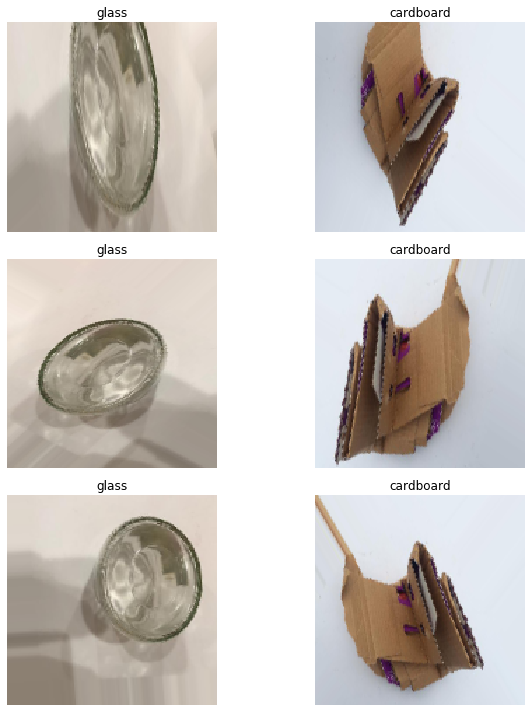

In [15]:
#Look at n random augmentations of the first 2 images from the first batch
#Issue: insure viz of each class transformed
classes =list(train_gen.class_indices.keys())
n=3
fig, axes = plt.subplots(n,2, figsize=(10,10))
for i in range(n):
    batch = train_gen[0] # returns first batch
    ax = plot_image(batch[0][0], ax= axes[i, 0])
    cls = classes[np.argmax(batch[1][0])]
    ax.set(title = cls)
    ax.axis('off')
    #plt.show()
    ax = plot_image(batch[0][1], ax=axes[i, 1])
    cls = classes[np.argmax(batch[1][1])]
    ax.set(title = cls)
    ax.axis('off') 
plt.tight_layout()
    #plt.show()

In [16]:
len(train_gen)

56

In [17]:
train_gen[0][0].shape

(32, 150, 150, 3)

In [18]:
train_gen[55][0].shape

(8, 150, 150, 3)

### Build model

Baseline  
Baseline + Dropout  
Baseline + Data Augmentation  
Baseline + Dropout + Data Augmentation  

In [19]:
ts = dt.datetime.now().strftime('%Y-%m-%d_%Hh%Mm%Ss')
ts

'2020-02-08_18h11m41s'

In [20]:
# Callbacks
bestmodelpath = '../saved models/model_epoch{epoch:02d}_{val_loss:.2f}_%s.h5' %(ts)
best_model = ModelCheckpoint(bestmodelpath, monitor='val_loss', verbose=1, save_best_only=True)

callback_list=[best_model]

In [21]:
#### Import model

# get model achitecture
model = build_models.get_model(desc=MODEL, IMG_SHAPE=IMG_SHAPE, OPT=OPT)


0.001
IMG_SHAPE: (150, 150)
OPT: opt-SGD-lr0.001


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1536)              54336736  
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 54,731,750
Trainable params: 395,014
Non-trainable params: 54,336,736
_________________________________________________________________


In [23]:
%%time
print('Starting to fit model...')
history = model.fit(train_gen,
           validation_data=val_gen,
           steps_per_epoch=len(train_gen),
           validation_steps=len(val_gen),
           epochs=EPOCH,
           callbacks=callback_list,
           verbose=.5
          )

Starting to fit model...
  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 56 steps, validate for 11 steps
Epoch 1/60



Epoch 00001: val_loss improved from inf to 1.93004, saving model to ../saved models/model_epoch01_1.93_2020-02-08_18h11m41s.h5


Epoch 2/60



Epoch 00002: val_loss improved from 1.93004 to 1.79930, saving model to ../saved models/model_epoch02_1.80_2020-02-08_18h11m41s.h5


Epoch 3/60



Epoch 00003: val_loss improved from 1.79930 to 1.73479, saving model to ../saved models/model_epoch03_1.73_2020-02-08_18h11m41s.h5


Epoch 4/60



Epoch 00004: val_loss improved from 1.73479 to 1.70249, saving model to ../saved models/model_epoch04_1.70_2020-02-08_18h11m41s.h5


Epoch 5/60



Epoch 00005: val_loss improved from 1.70249 to 1.64415, saving model to ../saved models/model_epoch05_1.64_2020-02-08_18h11m41s.h5


Epoch 6/60



Epoch 00006: val_loss improved from 1.64415 to 1.60775, saving model to ../saved models/model_epoch06_1.61_2020-02-08_18h11m41s.h5


Epoch 7/60



Epoch 00007: val_loss improved from 1.60775 to 1.56437, saving model to ../saved models/model_epoch07_1.56_2020-02-08_18h11m41s.h5


Epoch 8/60



Epoch 00008: val_loss improved from 1.56437 to 1.51121, saving model to ../saved models/model_epoch08_1.51_2020-02-08_18h11m41s.h5


Epoch 9/60



Epoch 00009: val_loss improved from 1.51121 to 1.46384, saving model to ../saved models/model_epoch09_1.46_2020-02-08_18h11m41s.h5


Epoch 10/60



Epoch 00010: val_loss did not improve from 1.46384
Epoch 11/60



Epoch 00011: val_loss improved from 1.46384 to 1.44631, saving model to ../saved models/model_epoch11_1.45_2020-02-08_18h11m41s.h5


Epoch 12/60



Epoch 00012: val_loss improved from 1.44631 to 1.40026, saving model to ../saved models/model_epoch12_1.40_2020-02-08_18h11m41s.h5


Epoch 13/60



Epoch 00013: val_loss improved from 1.40026 to 1.36227, saving model to ../saved models/model_epoch13_1.36_2020-02-08_18h11m41s.h5


Epoch 14/60



Epoch 00014: val_loss did not improve from 1.36227
Epoch 15/60



Epoch 00015: val_loss did not improve from 1.36227
Epoch 16/60



Epoch 00016: val_loss improved from 1.36227 to 1.33515, saving model to ../saved models/model_epoch16_1.34_2020-02-08_18h11m41s.h5


Epoch 17/60



Epoch 00017: val_loss improved from 1.33515 to 1.33089, saving model to ../saved models/model_epoch17_1.33_2020-02-08_18h11m41s.h5


Epoch 18/60



Epoch 00018: val_loss improved from 1.33089 to 1.32403, saving model to ../saved models/model_epoch18_1.32_2020-02-08_18h11m41s.h5


Epoch 19/60



Epoch 00019: val_loss improved from 1.32403 to 1.31571, saving model to ../saved models/model_epoch19_1.32_2020-02-08_18h11m41s.h5


Epoch 20/60



Epoch 00020: val_loss improved from 1.31571 to 1.30284, saving model to ../saved models/model_epoch20_1.30_2020-02-08_18h11m41s.h5


Epoch 21/60



Epoch 00021: val_loss did not improve from 1.30284
Epoch 22/60



Epoch 00022: val_loss did not improve from 1.30284
Epoch 23/60



Epoch 00023: val_loss improved from 1.30284 to 1.29485, saving model to ../saved models/model_epoch23_1.29_2020-02-08_18h11m41s.h5


Epoch 24/60



Epoch 00024: val_loss improved from 1.29485 to 1.29473, saving model to ../saved models/model_epoch24_1.29_2020-02-08_18h11m41s.h5


Epoch 25/60



Epoch 00025: val_loss did not improve from 1.29473
Epoch 26/60



Epoch 00026: val_loss improved from 1.29473 to 1.29251, saving model to ../saved models/model_epoch26_1.29_2020-02-08_18h11m41s.h5


Epoch 27/60



Epoch 00027: val_loss improved from 1.29251 to 1.28356, saving model to ../saved models/model_epoch27_1.28_2020-02-08_18h11m41s.h5


Epoch 28/60



Epoch 00028: val_loss did not improve from 1.28356
Epoch 29/60



Epoch 00029: val_loss improved from 1.28356 to 1.26113, saving model to ../saved models/model_epoch29_1.26_2020-02-08_18h11m41s.h5


Epoch 30/60



Epoch 00030: val_loss did not improve from 1.26113
Epoch 31/60



Epoch 00031: val_loss improved from 1.26113 to 1.26039, saving model to ../saved models/model_epoch31_1.26_2020-02-08_18h11m41s.h5


Epoch 32/60



Epoch 00032: val_loss did not improve from 1.26039
Epoch 33/60



Epoch 00033: val_loss did not improve from 1.26039
Epoch 34/60



Epoch 00034: val_loss did not improve from 1.26039
Epoch 35/60



Epoch 00035: val_loss did not improve from 1.26039
Epoch 36/60



Epoch 00036: val_loss did not improve from 1.26039
Epoch 37/60



Epoch 00037: val_loss did not improve from 1.26039
Epoch 38/60



Epoch 00038: val_loss did not improve from 1.26039
Epoch 39/60



Epoch 00039: val_loss did not improve from 1.26039
Epoch 40/60



Epoch 00040: val_loss did not improve from 1.26039
Epoch 41/60



Epoch 00041: val_loss did not improve from 1.26039
Epoch 42/60



Epoch 00042: val_loss did not improve from 1.26039
Epoch 43/60



Epoch 00043: val_loss did not improve from 1.26039
Epoch 44/60



Epoch 00044: val_loss did not improve from 1.26039
Epoch 45/60



Epoch 00045: val_loss did not improve from 1.26039
Epoch 46/60



Epoch 00046: val_loss did not improve from 1.26039
Epoch 47/60



Epoch 00047: val_loss did not improve from 1.26039
Epoch 48/60



Epoch 00048: val_loss did not improve from 1.26039
Epoch 49/60



Epoch 00049: val_loss did not improve from 1.26039
Epoch 50/60



Epoch 00050: val_loss did not improve from 1.26039
Epoch 51/60



Epoch 00051: val_loss did not improve from 1.26039
Epoch 52/60



Epoch 00052: val_loss did not improve from 1.26039
Epoch 53/60



Epoch 00053: val_loss did not improve from 1.26039
Epoch 54/60



Epoch 00054: val_loss did not improve from 1.26039
Epoch 55/60



Epoch 00055: val_loss did not improve from 1.26039
Epoch 56/60



Epoch 00056: val_loss did not improve from 1.26039
Epoch 57/60



Epoch 00057: val_loss did not improve from 1.26039
Epoch 58/60



Epoch 00058: val_loss did not improve from 1.26039
Epoch 59/60



Epoch 00059: val_loss did not improve from 1.26039
Epoch 60/60



Epoch 00060: val_loss did not improve from 1.26039
CPU times: user 4h 55min 52s, sys: 23min 42s, total: 5h 19min 35s
Wall time: 49min 12s


### Evaluate Model

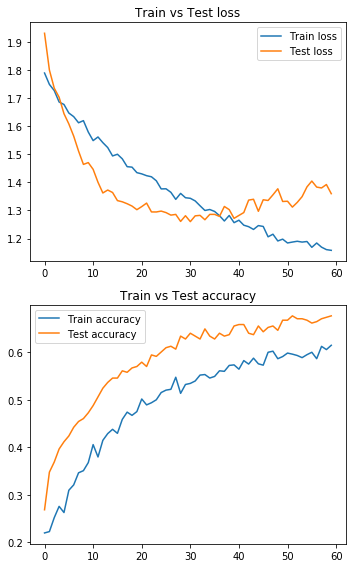

In [24]:
imgpath = '../figs/Train Test %s %s.png' %('accuracy', ts)
plot_tf_training(history, metric='accuracy', save=imgpath)

In [25]:
#ts = '2020-02-07_00h05m06s'
#sorted(glob.glob('../saved models/model_*_2020-02-06_23:35:05.h5'))[-1]
get_loss = lambda x: float(re.findall(r'_(\d\.\d{2})_', x)[0])
pat = '../saved models/model_epoch*_*_%s.h5' %(ts)
bestmodelpath = sorted(glob.glob(pat), key=get_loss)[0]
print(bestmodelpath)

../saved models/model_epoch29_1.26_2020-02-08_18h11m41s.h5


In [26]:
# write something to delete albut best?? (always latest?) model path
# glob for best model path around epoch????
bestmodel = load_model(bestmodelpath)

In [27]:
ytrue = val_gen.classes[val_gen.index_array]
proba_preds = bestmodel.predict(val_gen, steps=len(val_gen))
preds = np.argmax(proba_preds, axis=1)

In [28]:
out = metrics_report(ytrue, preds, classnames=val_gen.class_indices.keys())
out

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,cardboard,glass,metal,paper,plastic,trash,accuracy,macro avg,weighted avg
precision,0.928571,0.505263,0.826087,0.672897,0.573333,0.0,0.634146,0.584359,0.648296
recall,0.565217,0.738462,0.339286,0.867470,0.704918,0.0,0.634146,0.535892,0.634146
f1-score,0.702703,0.600000,0.481013,0.757895,0.632353,0.0,0.634146,0.528994,0.608963
support,46.000000,65.000000,56.000000,83.000000,61.000000,17.0,0.634146,328.000000,328.000000


In [29]:
val_gen.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

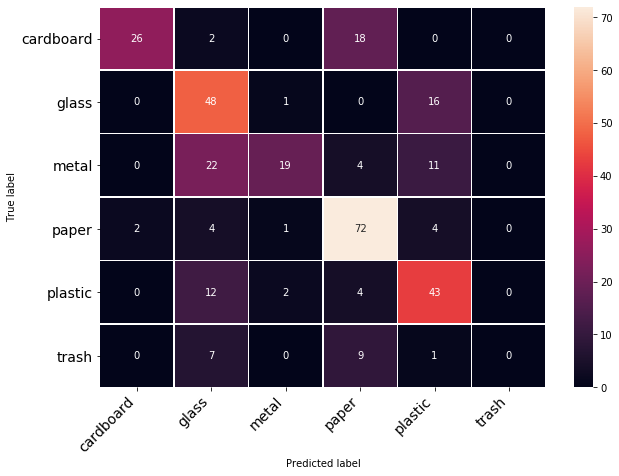

In [30]:
cm = confusion_matrix(ytrue, preds, class_names=val_gen.class_indices.keys())

In [31]:
top_epochs(history, metric='loss')

Best loss by epoch (1-indexed):


{1: 1.9300403920086948,
 2: 1.799298351461237,
 3: 1.7347862070257014,
 4: 1.7024871761148626,
 5: 1.644147981296886,
 6: 1.6077498522671787,
 7: 1.5643698193810203,
 8: 1.5112087293104692,
 10: 1.4702316305854104,
 9: 1.4638375585729426,
 11: 1.4463066946376453,
 56: 1.4045970710841091,
 12: 1.4002565470608799,
 59: 1.392266869544983,
 55: 1.3838637417012996,
 57: 1.3832072886553677,
 58: 1.380110263824463,
 49: 1.3772066614844582,
 14: 1.3727522871711038,
 15: 1.3639335198835894,
 13: 1.3622680685736916,
 60: 1.359736280007796,
 48: 1.355700899254192,
 54: 1.3492019393227317,
 44: 1.3398907509717075,
 46: 1.3381172526966443,
 43: 1.3369359970092773,
 47: 1.3356212811036543,
 16: 1.3351518728516318,
 51: 1.332887974652377,
 50: 1.332034409046173,
 17: 1.3308865969831294,
 53: 1.328715600750663,
 22: 1.3262615474787625,
 18: 1.3240308869968762,
 19: 1.3157052343541926,
 38: 1.3142846551808445,
 21: 1.313832169229334,
 52: 1.3120097788897427,
 39: 1.3030804991722107,
 20: 1.302836136384

In [32]:
top_epochs(history)

Best accuracy by epoch (1-indexed):


{52: 0.6768293,
 60: 0.6768293,
 59: 0.6737805,
 53: 0.6707317,
 54: 0.6707317,
 58: 0.6707317,
 50: 0.66768295,
 51: 0.66768295,
 55: 0.66768295,
 57: 0.66463417,
 56: 0.6615854,
 41: 0.6585366,
 42: 0.6585366,
 40: 0.6554878,
 45: 0.6554878,
 48: 0.6554878,
 47: 0.652439,
 34: 0.6493902,
 49: 0.64634144,
 46: 0.64329267,
 31: 0.6402439,
 37: 0.6402439,
 43: 0.6402439,
 39: 0.6371951,
 44: 0.6371951,
 29: 0.63414633,
 32: 0.63414633,
 35: 0.63414633,
 38: 0.63414633,
 30: 0.6280488,
 33: 0.6280488,
 36: 0.6280488,
 27: 0.6128049,
 26: 0.6097561,
 28: 0.60670733,
 25: 0.6006098,
 23: 0.5945122,
 24: 0.5914634,
 21: 0.5792683,
 20: 0.57012194,
 22: 0.57012194,
 19: 0.56707317,
 17: 0.5609756,
 18: 0.55792683,
 15: 0.5457317,
 16: 0.5457317,
 14: 0.5365854,
 13: 0.5243902,
 12: 0.50609756,
 11: 0.4878049,
 10: 0.47256097,
 9: 0.46036586,
 8: 0.4542683,
 7: 0.44207317,
 6: 0.4237805,
 5: 0.41158536,
 4: 0.39634147,
 3: 0.36890244,
 2: 0.34756097,
 1: 0.2682927}

In [33]:
# should keras drop out be applied after maxpool or before

#### Write Log

In [34]:
logdict = defaultdict(dict)
# data prep deets
logdict['train_data_gen_config'].update(vars(train_gen_config))
# to avoid saving the file name of everysingle image
logdict['train_data_gen'].update({k:v for k,v in vars(train_gen).items() if not isinstance(v,(np.ndarray, list))})

logdict['val_data_gen_config'].update(vars(val_gen_config))
logdict['val_data_gen'].update({k:v for k,v in vars(val_gen).items() if not isinstance(v,(np.ndarray, list))})

# model deets
logdict.update({'model_config': history.model.get_config()})# to_json() not used bc it returns string
logdict.update({'opt_config': history.model.optimizer.get_config()})
logdict.update({'model_history': history.history}) 
logdict.update({'fit_params': history.params})
logdict.update({'bestmodelpath': bestmodelpath})


# model val data metrics
logdict.update({'metrics_report': out.to_dict()})
logdict.update({'confusion_matrix': cm.to_dict()})

# misc
logdict.update({'run_id':ts})
logdict.update({'MODEL':MODEL, 'DATA_GEN_CONFIG':DATA_GEN_CONFIG})
logdict.update({'bestmodelpath': bestmodelpath})

In [35]:
dct = {ts: logdict} #; dct
logpath = '../logs/model_log.json'
write_log_json(dct, logpath, cls=NumpyEncoder)

**Diagnostics**

loss/acc by epoch graph  
classification report  
visualize filters?  
visualize mispredicted values?  
plot class level acc/metrics by epoch